In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from lib.data.cityscapes import (
    CityscapesPixelClassificationDataset,
    CityscapesLocalizationDataset,
)


def process_image(image, ds):
    # image = (image.transpose(1, 2, 0) * np.array(ds.std) + np.array(ds.mean)) * 255
    image = image.transpose(1, 2, 0) * 255
    image = image.astype(np.uint8)
    return image


def process_mask(seg_mask, ds):
    colored_mask = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
    for id, color in enumerate(ds.COLOR_PALETTE):
        colored_mask[seg_mask == id] = ds.COLOR_PALETTE[color]
    return colored_mask


def process_bboxes(image, bboxes, labels, ds):
    for idx, bbox in enumerate(bboxes):
        bbox = bbox.numpy().astype(np.int32)
        label = (
            ds.LOCALIZATION_CLASSES[labels[idx].item()] + " " + str(labels[idx].item())
        )
        color = ds.COLOR_PALETTE[11 + labels[idx].item()]

        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 5)

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
        image = cv2.rectangle(
            image, (bbox[0], bbox[1] - h - 10), (bbox[0] + w, bbox[1]), color, -1
        )
        image = cv2.putText(
            image,
            label,
            (bbox[0], bbox[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.2,
            [255, 255, 255],
            3,
        )
    return image


ds_dict = {
    "root": "data/cityscapes",
    "split": "train",
    "train_size": (1024, 1024),
    "val_size": (1024, 2048),
    "mean": (0.485, 0.456, 0.406),
    "std": (0.229, 0.224, 0.225),
    "ignore_index": 255,
    "bbox_format": "pascal_voc",
    "logger": None,
}

ds0 = CityscapesPixelClassificationDataset(**ds_dict)
ds1 = CityscapesLocalizationDataset(**ds_dict)

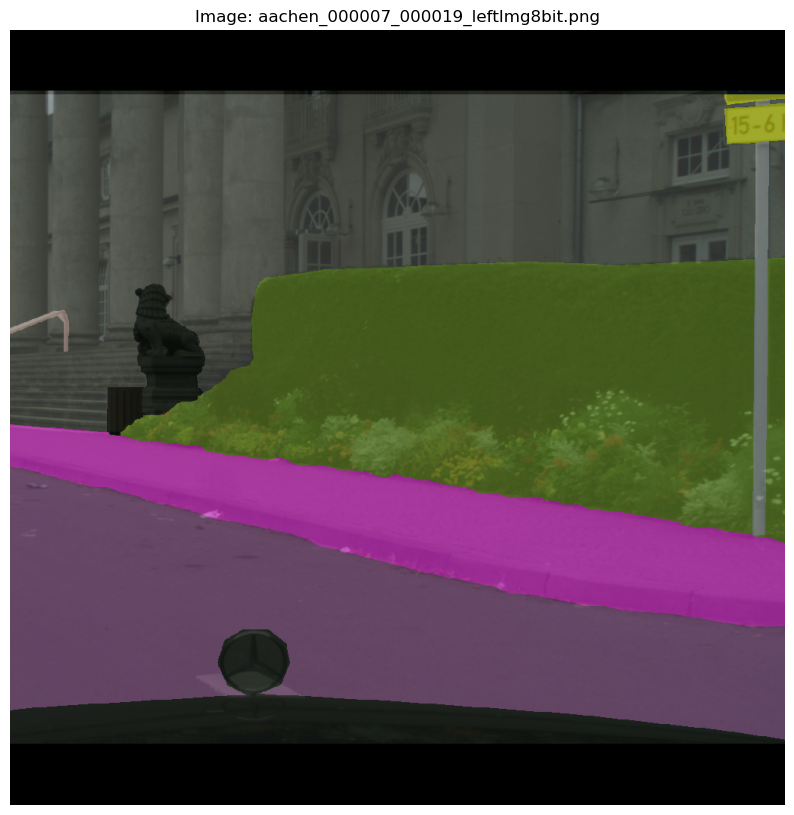

In [5]:
image, mask, infos = ds0[7]

image = process_image(image.numpy(), ds0)
seg_mask = mask.numpy().astype(np.uint8)
colored_mask = process_mask(seg_mask, ds0)

plt.figure(figsize=(10, 20))
plt.title(f"Image: {infos['name']}")
plt.imshow(image)
plt.imshow(colored_mask, alpha=0.55)
plt.axis("off")
plt.show()

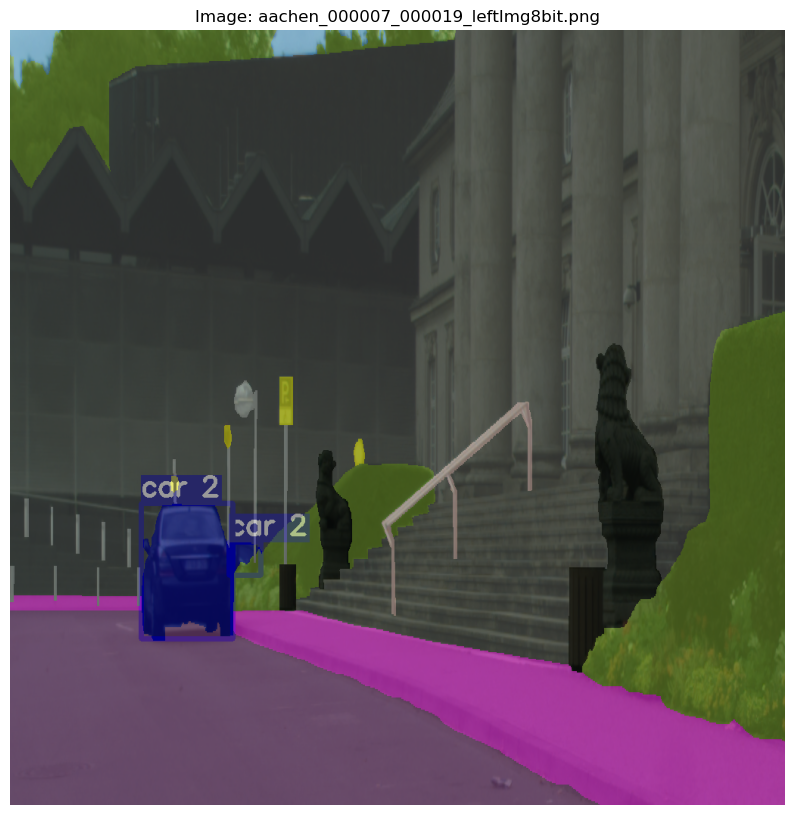

In [6]:
image, mask, bboxes, labels, heatmap, infos = ds1[7]

image = process_image(image.numpy(), ds1)
seg_mask = mask.numpy().astype(np.uint8)
colored_mask = process_mask(seg_mask, ds1)
image = process_bboxes(image.copy(), bboxes, labels, ds1)

plt.figure(figsize=(10, 20))
plt.title(f"Image: {infos['name']}")
plt.imshow(image)
plt.imshow(colored_mask, alpha=0.55)
plt.axis("off")
plt.show()

In [ ]:
# dict = {
#     0: 1,
#     1: 2,
#     2: 7,
#     3: 0,
#     4: 6,
#     5: 3,
#     6: 4,
#     7: 5,
# }

# with open("data/cityscapes/train.txt", "r") as fr:
#     lines = fr.read().splitlines()

# for line in lines:
#     with open("data/cityscapes/" + line.split()[-1], "r") as fr:
#         bboxes = fr.read().splitlines()

#     # print(bboxes)

#     with open("data/cityscapes/" + line.split()[-1], "w") as fw:
#         for bbox in bboxes:
#             fw.write(f"{dict[int(bbox.split()[0])]} {bbox.split()[1]} {bbox.split()[2]} {bbox.split()[3]} {bbox.split()[4]}\n")

#     # print(f"{dict[int(bboxes[0].split()[0])]} {bboxes[0].split()[1]} {bboxes[0].split()[2]} {bboxes[0].split()[3]} {bboxes[0].split()[4]}\n")


#     # break

In [ ]:
# with open("data/cityscapes/val.txt", "r") as fr:
#     lines = fr.read().splitlines()

# with open("data/cityscapes/val_new.txt", "w") as fw_main:
#     for line in lines:
#         img_path, mask_path, bbox_path = line.split()

#         with open("data/cityscapes/" + bbox_path, "r") as fr:
#             bboxes = fr.read().splitlines()

#         valid = []

#         for bbox in bboxes:
#             cls_id, x1, y1, x2, y2 = list(map(int, bbox.split()))
#             width = x2 - x1
#             height = y2 - y1
#             if width > 10 and height > 10:
#                 valid.append((cls_id, x1, y1, x2, y2))

#             # break

#         if not valid:
#             continue

#         with open("data/cityscapes/" + bbox_path, "w") as fw:
#             for cls_id, x1, y1, x2, y2 in valid:
#                 fw.write(f"{cls_id} {x1} {x2} {y1} {y2}\n")

#         fw_main.write(f"{img_path} {mask_path} {bbox_path}\n")

#         # break

In [ ]:
import cv2
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from lib.model.network import Network
from lib.data.cityscapes import CityscapesDataset


class Model(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        classifier, (centerness, regression) = self.model(x)
        return classifier.argmax(dim=1, keepdims=True), (centerness, regression)


def process_mask(seg_mask, ds):
    # colored_mask = np.zeros((*image.shape[:2], 3), dtype=np.uint8)
    colored_mask = np.zeros((512, 1024, 3), dtype=np.uint8)
    for id, color in enumerate(ds.COLOR_PALETTE):
        colored_mask[seg_mask == id] = ds.COLOR_PALETTE[color]
    return colored_mask


def process_bboxes(image, bboxes, labels, ds):
    for idx, bbox in enumerate(bboxes):
        bbox = bbox.numpy().astype(np.int32)
        label = (
            ds.LOCALIZATION_CLASSES[labels[idx].item()] + " " + str(labels[idx].item())
        )
        color = ds.COLOR_PALETTE[11 + labels[idx].item()]

        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 5)

        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)
        image = cv2.rectangle(
            image, (bbox[0], bbox[1] - h - 10), (bbox[0] + w, bbox[1]), color, -1
        )
        image = cv2.putText(
            image,
            label,
            (bbox[0], bbox[1] - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.2,
            [255, 255, 255],
            3,
        )
    return image


model = Network(
    localization_classes=8,
    classification_classes=19,
    head_channels=64,
    ppm_block="ce",
)

work_dir = "exp/paper_exp1_0.1_bbox_loss/"
model_path = work_dir + "checkpoints/model_best.pth"
snapshot = torch.load(model_path)

print(f"Loading model from {model_path} at epoch {snapshot['epoch']}\n")

state_dict = snapshot["model_state_dict"]

state_dict = {
    k.replace("model.", ""): v for k, v in state_dict.items() if k.startswith("model.")
}

model.load_state_dict(state_dict, strict=False)

model = Model(model)
model.eval()

ds = CityscapesDataset(
    root="data/cityscapes",
    split="val",
    train_size=(512, 1024),
    val_size=(512, 1024),
    mean=(0.485, 0.456, 0.406),
    std=(0.229, 0.224, 0.225),
    ignore_index=255,
    bbox_format="pascal_voc",
    logger=None,
)

In [ ]:
image, bboxes, labels, map, heatmap, info = ds[1]


with torch.no_grad():
    classification, (centerness, regression) = model(image.unsqueeze(0))

for idx in range(8):
    print(idx, centerness[0][idx].max())

In [ ]:
topk = 100
score_threshold = 0.25
b, _, h, w = centerness.shape

detections = []

center_max = F.max_pool2d(centerness, kernel_size=3, stride=1, padding=1)
center_mask = (center_max == centerness).float()
centerness = centerness * center_mask

for batch in range(b):

    scores, indices = torch.topk(centerness[batch].view(-1), k=topk)

    scores = scores[scores >= score_threshold]
    topk_indices = indices[: len(scores)]

    print(len(scores))

    labels = (topk_indices / (h * w)).int()
    indices = topk_indices % (h * w)

    xs_orig = (indices % w).int()
    ys_orig = (indices / w).int()

    wh = regression[batch][:, ys_orig, xs_orig]

    half_w, half_h = wh[0] / 2, wh[1] / 2

    bboxes = torch.stack(
        [
            xs_orig - half_w,
            ys_orig - half_h,
            xs_orig + half_w,
            ys_orig + half_h,
        ],
        dim=1,
    )

    detections.append([bboxes, scores, labels])

detections

In [ ]:
seg = classification[0][0]
seg = process_mask(seg.numpy(), ds)

inv_image = (
    (
        (
            (image.numpy() * np.array(ds.std).reshape(3, 1, 1))
            + np.array(ds.mean).reshape(3, 1, 1)
        )
        * 255
    )
    .transpose(1, 2, 0)
    .astype(np.uint8)
)
final = process_bboxes(inv_image.copy(), bboxes, labels, ds)

plt.imshow(final)
plt.imshow(seg, alpha=0.55)